I. Setup

After implemented from scratch multiclass logistic regression and after tested it we can now do next steps to increase efficiency, effectiveness and upgrade this base model.

Here it is abstract class of Logistic regression with empty fit function, we need to implement this fit function by yourself, because in next steps we will be adding there some upgrades and we need different class to compare it later

In [332]:
import time

from scipy.odr import polynomial
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import LabelEncoder

In [310]:
# Loading data
df = pd.read_csv("dataset.csv")
df.head()

numerical_features = [
    "Application order","Age at enrollment", "Curricular units 1st sem (credited)", "Curricular units 1st sem (enrolled)",
    "Curricular units 1st sem (evaluations)","Curricular units 1st sem (approved)","Curricular units 1st sem (grade)",
    "Curricular units 1st sem (without evaluations)","Curricular units 2nd sem (credited)","Curricular units 2nd sem (enrolled)",
    "Curricular units 2nd sem (evaluations)","Curricular units 2nd sem (approved)",
    "Curricular units 2nd sem (without evaluations)","Unemployment rate","Inflation rate","GDP","Curricular units 2nd sem (grade)"
]
categorical_features = [
    "Marital status","Application mode","Course","Daytime/evening attendance","Previous qualification","Nationality",
    "Mother's qualification","Father's qualification","Mother's occupation","Father's occupation","Displaced",
    "Educational special needs","Debtor","Tuition fees up to date","Gender","Scholarship holder","International"
]

target = "Target"

preprocessor_full_set = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore',sparse_output=False), categorical_features)
    ]
)
def transform_in_pipeline(preproc,X_ttrain,X_ttest,y_ttrain,y_ttest):
    return  (preproc.fit_transform(X_ttrain), preproc.transform(X_ttest),
             pd.get_dummies(y_ttrain,columns=["Target"]).astype(int).to_numpy(), pd.get_dummies(y_ttest,columns=["Target"]).astype(int).to_numpy())


In [312]:
# HERE Y has to be in onehotencoder [0 0 ...  1]
X = df.drop(["Target"], axis=1)
y = df["Target"]


X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=42)


In [236]:
from abc import ABC, abstractmethod
class LogisticRegression(ABC):
    def __init__(self, lr=0.001, n_iters=5000, batch_size=64):
        self.lr = lr
        self.batch_idx = 0
        self.n_iters = n_iters
        self.batch_size = batch_size
        self.weights = None
        self.bias = None
        self.errors = []
        self.n_classes = None
        self.probabilities = None
    def error_function(self, y, predicted, m_samples):
        return -np.sum(y * np.log(predicted + 1e-15)) / m_samples

    def softmax(self,z):
        return np.exp(z)/np.sum(np.exp(z),axis=1,keepdims=True)

    def predict(self, X):
        z = np.dot(X, self.weights) + self.bias
        return self.softmax(z)

    def predict_class(self, X_test):
        probabilities = self.predict(X_test)
        self.probabilities = probabilities
        return np.argmax(probabilities, axis=1).reshape(-1, 1)

    def score(self, predicted, y):
        y_true = np.argmax(y, axis=1)
        correct = (predicted.flatten() == y_true)
        accuracy = np.mean(correct)
        return accuracy

    def raw_error_data(self):
        return np.arange(len(self.errors)), self.errors

    @abstractmethod
    def fit(self, X, y):
       ...

First we start with base multiclass logistic regression without any specific upgrades

In [237]:
class BaseLogisticRegression(LogisticRegression):
    def fit(self,X,y):
        m_samples, n_features = X.shape
        self.n_classes = y.shape[1]
        self.weights = np.zeros((n_features, self.n_classes))
        self.bias = np.zeros((1, self.n_classes))
        self.errors.clear()

        for i in range(self.n_iters):
            indices = np.random.permutation(m_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for start_idx in range(0, m_samples, self.batch_size):
                end_idx = start_idx + self.batch_size
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]

                predict = self.predict(X_batch)
                dw = (1 / X_batch.shape[0]) * np.dot(X_batch.T, (predict - y_batch))
                db = (1 / X_batch.shape[0]) * np.sum(predict - y_batch, axis=0, keepdims=True)

                self.weights -= self.lr * dw
                self.bias -= self.lr * db

            full_predict = self.predict(X)
            loss = self.error_function(y, full_predict, m_samples)
            self.errors.append(loss)

            if i % 100 == 0:
                print(f"Iteration {i}, Loss: {loss:.4f}")




Now we can train and predict results on these subsets, which were made with random_state=$42$

In [12]:
X_train_proc,X_test_proc,y_train_proc,y_test_proc = transform_in_pipeline(preprocessor_full_set,X_train, X_test, y_train, y_test)

logistic_regression1 = BaseLogisticRegression(n_iters=5000, lr=0.001, batch_size=64)

In [13]:
logistic_regression1.fit(X_train_proc, y_train_proc)
predicted = logistic_regression1.predict_class(X_test_proc)

logistic_regression1.score(predicted, y_test_proc)

Iteration 0, Loss: 1.0448
Iteration 100, Loss: 0.6512
Iteration 200, Loss: 0.6082
Iteration 300, Loss: 0.5876
Iteration 400, Loss: 0.5747
Iteration 500, Loss: 0.5655
Iteration 600, Loss: 0.5584
Iteration 700, Loss: 0.5527
Iteration 800, Loss: 0.5480
Iteration 900, Loss: 0.5440
Iteration 1000, Loss: 0.5406
Iteration 1100, Loss: 0.5376
Iteration 1200, Loss: 0.5349
Iteration 1300, Loss: 0.5325
Iteration 1400, Loss: 0.5303
Iteration 1500, Loss: 0.5284
Iteration 1600, Loss: 0.5266
Iteration 1700, Loss: 0.5250
Iteration 1800, Loss: 0.5235
Iteration 1900, Loss: 0.5221
Iteration 2000, Loss: 0.5209
Iteration 2100, Loss: 0.5197
Iteration 2200, Loss: 0.5186
Iteration 2300, Loss: 0.5175
Iteration 2400, Loss: 0.5166
Iteration 2500, Loss: 0.5157
Iteration 2600, Loss: 0.5148
Iteration 2700, Loss: 0.5140
Iteration 2800, Loss: 0.5132
Iteration 2900, Loss: 0.5125
Iteration 3000, Loss: 0.5118
Iteration 3100, Loss: 0.5111
Iteration 3200, Loss: 0.5105
Iteration 3300, Loss: 0.5099
Iteration 3400, Loss: 0.50

np.float64(0.766566265060241)

But now we can change this random_state variable to show that is random to generate a subsets,and based on this random we can get bad or worse score

In [14]:
X_train2,X_test2,y_train2,y_test2 = train_test_split(X,y,train_size=0.7,random_state=11)
X_train_proc2,X_test_proc2,y_train_proc2,y_test_proc2 = transform_in_pipeline(preprocessor_full_set,X_train2, X_test2, y_train2, y_test2)

logistic_regression2 = BaseLogisticRegression(n_iters=5000, lr=0.001, batch_size=64)


In [15]:
logistic_regression2.fit(X_train_proc2, y_train_proc2)
predicted2 = logistic_regression2.predict_class(X_test_proc2)
logistic_regression2.score(predicted2, y_test_proc2)

Iteration 0, Loss: 1.0468
Iteration 100, Loss: 0.6528
Iteration 200, Loss: 0.6092
Iteration 300, Loss: 0.5881
Iteration 400, Loss: 0.5749
Iteration 500, Loss: 0.5653
Iteration 600, Loss: 0.5580
Iteration 700, Loss: 0.5520
Iteration 800, Loss: 0.5471
Iteration 900, Loss: 0.5429
Iteration 1000, Loss: 0.5393
Iteration 1100, Loss: 0.5362
Iteration 1200, Loss: 0.5334
Iteration 1300, Loss: 0.5310
Iteration 1400, Loss: 0.5287
Iteration 1500, Loss: 0.5267
Iteration 1600, Loss: 0.5249
Iteration 1700, Loss: 0.5233
Iteration 1800, Loss: 0.5218
Iteration 1900, Loss: 0.5204
Iteration 2000, Loss: 0.5191
Iteration 2100, Loss: 0.5179
Iteration 2200, Loss: 0.5168
Iteration 2300, Loss: 0.5157
Iteration 2400, Loss: 0.5147
Iteration 2500, Loss: 0.5138
Iteration 2600, Loss: 0.5130
Iteration 2700, Loss: 0.5122
Iteration 2800, Loss: 0.5114
Iteration 2900, Loss: 0.5107
Iteration 3000, Loss: 0.5100
Iteration 3100, Loss: 0.5093
Iteration 3200, Loss: 0.5087
Iteration 3300, Loss: 0.5081
Iteration 3400, Loss: 0.50

np.float64(0.7710843373493976)


\begin{align*}
\text{accuracy}(\text{random\_state} = 42) &= 0.7665 \\
\text{accuracy}(\text{random\_state} = 11) &= 0.7710
\end{align*}

And we can see that is real random, so we have to find way to do this more independent of random_state


II. Cross validation (StratifiedKFold)

In [16]:
from sklearn.model_selection import StratifiedKFold

def make_cross_validation_predict(model,preproc, X_set, y_set, k=3):
    scores = []
    skf = StratifiedKFold(k, shuffle=True)

    y_encoded = LabelEncoder().fit_transform(y_set)

    for train_index, test_index in skf.split(X_set, y_encoded):
        X_train_raw = X_set.iloc[train_index]
        X_test_raw = X_set.iloc[test_index]

        y_train_raw = y_set.iloc[train_index]
        y_test_raw = y_set.iloc[test_index]

        X_train = preproc.fit_transform(X_train_raw)
        X_test = preproc.transform(X_test_raw)

        y_train = pd.get_dummies(y_train_raw).astype(int).to_numpy()
        y_test = pd.get_dummies(y_test_raw).astype(int).to_numpy()
        model.fit(X_train, y_train)
        predicted = model.predict_class(X_test)
        score = model.score(predicted, y_test)
        scores.append(score)


    return scores, np.mean(scores)


In [17]:
logistic_regression3 = BaseLogisticRegression(n_iters=5000, lr=0.001, batch_size=64)

make_cross_validation_predict(logistic_regression3, preprocessor_full_set, X_train, y_train)

Iteration 0, Loss: 1.0605
Iteration 100, Loss: 0.6762
Iteration 200, Loss: 0.6259
Iteration 300, Loss: 0.6009
Iteration 400, Loss: 0.5853
Iteration 500, Loss: 0.5742
Iteration 600, Loss: 0.5658
Iteration 700, Loss: 0.5591
Iteration 800, Loss: 0.5536
Iteration 900, Loss: 0.5489
Iteration 1000, Loss: 0.5448
Iteration 1100, Loss: 0.5412
Iteration 1200, Loss: 0.5380
Iteration 1300, Loss: 0.5351
Iteration 1400, Loss: 0.5325
Iteration 1500, Loss: 0.5302
Iteration 1600, Loss: 0.5280
Iteration 1700, Loss: 0.5260
Iteration 1800, Loss: 0.5241
Iteration 1900, Loss: 0.5224
Iteration 2000, Loss: 0.5208
Iteration 2100, Loss: 0.5193
Iteration 2200, Loss: 0.5179
Iteration 2300, Loss: 0.5165
Iteration 2400, Loss: 0.5153
Iteration 2500, Loss: 0.5141
Iteration 2600, Loss: 0.5130
Iteration 2700, Loss: 0.5119
Iteration 2800, Loss: 0.5109
Iteration 2900, Loss: 0.5100
Iteration 3000, Loss: 0.5091
Iteration 3100, Loss: 0.5082
Iteration 3200, Loss: 0.5074
Iteration 3300, Loss: 0.5066
Iteration 3400, Loss: 0.50

([np.float64(0.7761627906976745),
  np.float64(0.7722868217054264),
  np.float64(0.7664728682170543)],
 np.float64(0.7716408268733851))

And now we can see this what we saw before, that in every run, we get different prediction. So for this reason using cross-validation is is important therefore in next step of upgrades we will be using this method.


II. Over/under-fitting and error plot

First we have to search if we have either overfitting or underfitting using our base logistic regression model.

In [18]:
base_CV_logistic_regression = BaseLogisticRegression(n_iters=5000, lr=0.001, batch_size=64)
make_cross_validation_predict(base_CV_logistic_regression, preprocessor_full_set, X_train, y_train)

Iteration 0, Loss: 1.0600
Iteration 100, Loss: 0.6695
Iteration 200, Loss: 0.6183
Iteration 300, Loss: 0.5930
Iteration 400, Loss: 0.5771
Iteration 500, Loss: 0.5659
Iteration 600, Loss: 0.5574
Iteration 700, Loss: 0.5505
Iteration 800, Loss: 0.5447
Iteration 900, Loss: 0.5399
Iteration 1000, Loss: 0.5356
Iteration 1100, Loss: 0.5319
Iteration 1200, Loss: 0.5285
Iteration 1300, Loss: 0.5255
Iteration 1400, Loss: 0.5228
Iteration 1500, Loss: 0.5203
Iteration 1600, Loss: 0.5180
Iteration 1700, Loss: 0.5158
Iteration 1800, Loss: 0.5139
Iteration 1900, Loss: 0.5121
Iteration 2000, Loss: 0.5104
Iteration 2100, Loss: 0.5088
Iteration 2200, Loss: 0.5073
Iteration 2300, Loss: 0.5059
Iteration 2400, Loss: 0.5046
Iteration 2500, Loss: 0.5033
Iteration 2600, Loss: 0.5021
Iteration 2700, Loss: 0.5010
Iteration 2800, Loss: 0.4999
Iteration 2900, Loss: 0.4989
Iteration 3000, Loss: 0.4980
Iteration 3100, Loss: 0.4970
Iteration 3200, Loss: 0.4961
Iteration 3300, Loss: 0.4953
Iteration 3400, Loss: 0.49

([np.float64(0.7742248062015504),
  np.float64(0.7771317829457365),
  np.float64(0.7625968992248062)],
 np.float64(0.7713178294573644))

In [19]:
base_logistic_regression = BaseLogisticRegression(n_iters=5000, lr=0.001, batch_size=64)

In [20]:
#train base_logistic_regression
base_logistic_regression.fit(X_train_proc,y_train_proc)

Iteration 0, Loss: 1.0453
Iteration 100, Loss: 0.6511
Iteration 200, Loss: 0.6082
Iteration 300, Loss: 0.5876
Iteration 400, Loss: 0.5746
Iteration 500, Loss: 0.5655
Iteration 600, Loss: 0.5584
Iteration 700, Loss: 0.5528
Iteration 800, Loss: 0.5480
Iteration 900, Loss: 0.5440
Iteration 1000, Loss: 0.5406
Iteration 1100, Loss: 0.5376
Iteration 1200, Loss: 0.5349
Iteration 1300, Loss: 0.5325
Iteration 1400, Loss: 0.5303
Iteration 1500, Loss: 0.5284
Iteration 1600, Loss: 0.5266
Iteration 1700, Loss: 0.5250
Iteration 1800, Loss: 0.5235
Iteration 1900, Loss: 0.5221
Iteration 2000, Loss: 0.5209
Iteration 2100, Loss: 0.5197
Iteration 2200, Loss: 0.5186
Iteration 2300, Loss: 0.5175
Iteration 2400, Loss: 0.5166
Iteration 2500, Loss: 0.5157
Iteration 2600, Loss: 0.5148
Iteration 2700, Loss: 0.5140
Iteration 2800, Loss: 0.5132
Iteration 2900, Loss: 0.5125
Iteration 3000, Loss: 0.5118
Iteration 3100, Loss: 0.5111
Iteration 3200, Loss: 0.5105
Iteration 3300, Loss: 0.5099
Iteration 3400, Loss: 0.50

In [21]:
predicted = base_logistic_regression.predict_class(X_train_proc)
print(base_logistic_regression.score(predicted, y_train_proc))
x1,y1 = base_logistic_regression.raw_error_data()


0.8020025839793282


In [22]:
predicted = base_logistic_regression.predict_class(X_test_proc)
print(base_logistic_regression.score(predicted, y_test_proc))
x2,y2 = base_logistic_regression.raw_error_data()

0.766566265060241


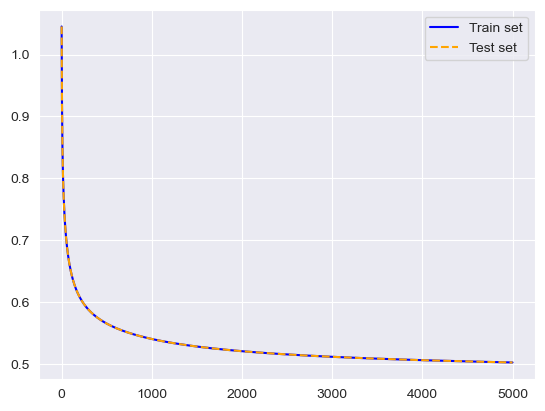

In [23]:
plt.plot(x1, y1, label="Train set", color='blue', linestyle='-')
plt.plot(x2, y2, label="Test set", color='orange', linestyle='--')

plt.legend()
plt.show()


Based on this plot we can say that our lines are close to each other, so we don't have problem with under or over-fitting

And also we have scores:
\begin{align*}
\text{accuracy}(\text{CV}) &= 0.7719 \\
\text{accuracy}(\text{on train}) &= 0.8016 \\
\text{accuracy}(\text{on test}) &= 0.7665
\end{align*}
We can see that $Test~\approx~CV~\approx~Train$ so it means that we don't have problem with underfitting or overfitting

Although we don't have problem with under/over - fitting still we can try to improve model with PolynomialFeatures


In [24]:
numerical_pipeline_poly = Pipeline([
    ('poly',PolynomialFeatures(degree=2,include_bias=False)),
    ('scaler',StandardScaler())
])

polynomial_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline_poly, numerical_features),
        ('cat',OneHotEncoder(handle_unknown='ignore',sparse_output=False),categorical_features)
    ]
)


In [25]:
polynomial_CV_logistic_regression = BaseLogisticRegression(n_iters=5000, lr=0.001, batch_size=64)
make_cross_validation_predict(polynomial_CV_logistic_regression, polynomial_preprocessor, X_train, y_train)

Iteration 0, Loss: 0.9904
Iteration 100, Loss: 0.5995
Iteration 200, Loss: 0.5679
Iteration 300, Loss: 0.5498
Iteration 400, Loss: 0.5371
Iteration 500, Loss: 0.5273
Iteration 600, Loss: 0.5195
Iteration 700, Loss: 0.5130
Iteration 800, Loss: 0.5074
Iteration 900, Loss: 0.5025
Iteration 1000, Loss: 0.4983
Iteration 1100, Loss: 0.4944
Iteration 1200, Loss: 0.4909
Iteration 1300, Loss: 0.4878
Iteration 1400, Loss: 0.4849
Iteration 1500, Loss: 0.4822
Iteration 1600, Loss: 0.4798
Iteration 1700, Loss: 0.4774
Iteration 1800, Loss: 0.4753
Iteration 1900, Loss: 0.4732
Iteration 2000, Loss: 0.4713
Iteration 2100, Loss: 0.4695
Iteration 2200, Loss: 0.4678
Iteration 2300, Loss: 0.4662
Iteration 2400, Loss: 0.4646
Iteration 2500, Loss: 0.4632
Iteration 2600, Loss: 0.4617
Iteration 2700, Loss: 0.4604
Iteration 2800, Loss: 0.4591
Iteration 2900, Loss: 0.4579
Iteration 3000, Loss: 0.4567
Iteration 3100, Loss: 0.4556
Iteration 3200, Loss: 0.4545
Iteration 3300, Loss: 0.4534
Iteration 3400, Loss: 0.45

([np.float64(0.7616279069767442),
  np.float64(0.7790697674418605),
  np.float64(0.7790697674418605)],
 np.float64(0.7732558139534884))

In [26]:
X_train_proc_poly,X_test_proc_poly,y_train_proc_poly,y_test_proc_poly = transform_in_pipeline(polynomial_preprocessor,X_train, X_test, y_train, y_test)

In [27]:
polynomial_base_logistic_regression = BaseLogisticRegression(n_iters=5000, lr=0.001, batch_size=64)
polynomial_base_logistic_regression.fit(X_train_proc_poly,y_train_proc_poly)

Iteration 0, Loss: 0.9519
Iteration 100, Loss: 0.5905
Iteration 200, Loss: 0.5638
Iteration 300, Loss: 0.5489
Iteration 400, Loss: 0.5388
Iteration 500, Loss: 0.5311
Iteration 600, Loss: 0.5250
Iteration 700, Loss: 0.5199
Iteration 800, Loss: 0.5156
Iteration 900, Loss: 0.5118
Iteration 1000, Loss: 0.5085
Iteration 1100, Loss: 0.5055
Iteration 1200, Loss: 0.5029
Iteration 1300, Loss: 0.5004
Iteration 1400, Loss: 0.4982
Iteration 1500, Loss: 0.4961
Iteration 1600, Loss: 0.4942
Iteration 1700, Loss: 0.4924
Iteration 1800, Loss: 0.4907
Iteration 1900, Loss: 0.4891
Iteration 2000, Loss: 0.4876
Iteration 2100, Loss: 0.4862
Iteration 2200, Loss: 0.4849
Iteration 2300, Loss: 0.4836
Iteration 2400, Loss: 0.4824
Iteration 2500, Loss: 0.4812
Iteration 2600, Loss: 0.4802
Iteration 2700, Loss: 0.4791
Iteration 2800, Loss: 0.4781
Iteration 2900, Loss: 0.4771
Iteration 3000, Loss: 0.4762
Iteration 3100, Loss: 0.4753
Iteration 3200, Loss: 0.4745
Iteration 3300, Loss: 0.4737
Iteration 3400, Loss: 0.47

In [28]:
predicted = polynomial_base_logistic_regression.predict_class(X_train_proc_poly)
print(polynomial_base_logistic_regression.score(predicted, y_train_proc_poly))

0.8126614987080103


In [29]:
predicted = polynomial_base_logistic_regression.predict_class(X_test_proc_poly)
print(polynomial_base_logistic_regression.score(predicted, y_test_proc_poly))

0.7718373493975904


And we can see that we get little better scores using this modified preprocessor.

Now we can ask question, do we need all of the columns in training our model, maybe we can delete some of them and our score won't be worse

In [314]:
numerical_features_modified = [
    "Application order","Age at enrollment", "Curricular units 1st sem (credited)", "Curricular units 1st sem (enrolled)",
    "Curricular units 1st sem (evaluations)","Curricular units 1st sem (approved)","Curricular units 1st sem (grade)",
    "Curricular units 1st sem (without evaluations)","Curricular units 2nd sem (credited)","Curricular units 2nd sem (enrolled)",
    "Curricular units 2nd sem (evaluations)","Curricular units 2nd sem (approved)",
    "Curricular units 2nd sem (without evaluations)","Curricular units 2nd sem (grade)"
]
categorical_features_modified = [
    "Marital status","Application mode","Course","Daytime/evening attendance","Previous qualification",
    "Mother's qualification","Father's qualification","Mother's occupation","Father's occupation","Displaced",
    "Educational special needs","Debtor","Tuition fees up to date","Gender","Scholarship holder"
]


df_modified = pd.read_csv("dataset.csv")
#pipeline

In [315]:
y = df_modified["Target"]
X = df_modified[numerical_features_modified+categorical_features_modified]

In [316]:
numerical_pipeline_modified_features = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())
])

modified_features_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline_modified_features, numerical_features_modified),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features_modified)
    ]
)
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.7,random_state=42)

In [257]:
modified_features_CV_logistic_regression = BaseLogisticRegression(n_iters=5000, lr=0.001, batch_size=64)
print(make_cross_validation_predict(modified_features_CV_logistic_regression, modified_features_preprocessor, X_train, y_train))
print(modified_features_CV_logistic_regression.weights)

Iteration 0, Loss: 1.0001
Iteration 100, Loss: 0.6038
Iteration 200, Loss: 0.5732
Iteration 300, Loss: 0.5563
Iteration 400, Loss: 0.5449
Iteration 500, Loss: 0.5364
Iteration 600, Loss: 0.5297
Iteration 700, Loss: 0.5242
Iteration 800, Loss: 0.5195
Iteration 900, Loss: 0.5155
Iteration 1000, Loss: 0.5119
Iteration 1100, Loss: 0.5087
Iteration 1200, Loss: 0.5059
Iteration 1300, Loss: 0.5032
Iteration 1400, Loss: 0.5008
Iteration 1500, Loss: 0.4986
Iteration 1600, Loss: 0.4966
Iteration 1700, Loss: 0.4946
Iteration 1800, Loss: 0.4928
Iteration 1900, Loss: 0.4911
Iteration 2000, Loss: 0.4894
Iteration 2100, Loss: 0.4879
Iteration 2200, Loss: 0.4865
Iteration 2300, Loss: 0.4851
Iteration 2400, Loss: 0.4838
Iteration 2500, Loss: 0.4825
Iteration 2600, Loss: 0.4813
Iteration 2700, Loss: 0.4801
Iteration 2800, Loss: 0.4790
Iteration 2900, Loss: 0.4780
Iteration 3000, Loss: 0.4769
Iteration 3100, Loss: 0.4759
Iteration 3200, Loss: 0.4750
Iteration 3300, Loss: 0.4741
Iteration 3400, Loss: 0.47

hAfter few tries we got new sets of features, which is smaller that entry features set, and now score after CV is slightly better.

Moving to the next steps, we are going with:

- smaller dataset
- `modified_features_preprocessor` preprocessor with `PolynomialFeatures`
- `X_train`, `X_test`, `y_train`, `y_test`


III. L1, L2 regularization
importance of the input

Regularization method are applied to regression model because we want to have more control on weights in our model, because weights are responsible for features importance in
training model. So we can use regularization techniques to work on these  weights. We to penalize model for to high weights.

- `L1 (lasso)`
$\lambda \sum_{i,j} |W_{ij}|$

This method are going to even make some features zero by zero weight to eliminate unnecessary feautres
- `L2 (ridge)`
$\lambda \sum_{i,j} W_{ij}^2$

This method are going to penalize model more significant because of square

In [34]:
#X_train_proc,X_test_proc,y_train_proc,y_test_proc = transform_in_pipeline(polynomial_preprocessor,X_train, X_test, y_train, y_test)

In [238]:
class BaseLogisticRegressionRegL1(LogisticRegression):
    def __init__(self,n_iters=5000, lr=0.001, batch_size=64,l=0.001):
        super().__init__(lr, n_iters, batch_size)
        self.l = l

    def fit(self,X,y):
        m_samples, n_features = X.shape
        self.n_classes = y.shape[1]
        self.weights = np.zeros((n_features, self.n_classes))
        self.bias = np.zeros((1, self.n_classes))
        self.errors.clear()

        for i in range(self.n_iters):
            indices = np.random.permutation(m_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for start_idx in range(0, m_samples, self.batch_size):
                end_idx = start_idx + self.batch_size
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]

                predict = self.predict(X_batch)
                dw = (1 / X_batch.shape[0]) * np.dot(X_batch.T, (predict - y_batch))

                dw+=self.l * np.sign(self.weights)

                db = (1 / X_batch.shape[0]) * np.sum(predict - y_batch, axis=0, keepdims=True)

                self.weights -= self.lr * dw
                self.bias -= self.lr * db

            full_predict = self.predict(X)
            loss = self.error_function(y, full_predict, m_samples)
            self.errors.append(loss)

            if i % 100 == 0:
                print(f"Iteration {i}, Loss: {loss:.4f}")



In [239]:
class BaseLogisticRegressionRegL2(LogisticRegression):
    def __init__(self,n_iters=5000, lr=0.001, batch_size=64,l=0.001):
        super().__init__(lr, n_iters, batch_size)
        self.l = l
    def fit(self,X,y):
        m_samples, n_features = X.shape
        self.n_classes = y.shape[1]
        self.weights = np.zeros((n_features, self.n_classes))
        self.bias = np.zeros((1, self.n_classes))
        self.errors.clear()

        for i in range(self.n_iters):
            indices = np.random.permutation(m_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for start_idx in range(0, m_samples, self.batch_size):
                end_idx = start_idx + self.batch_size
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]

                predict = self.predict(X_batch)
                dw = (1 / X_batch.shape[0]) * np.dot(X_batch.T, (predict - y_batch))

                dw += self.l * 2 * self.weights

                db = (1 / X_batch.shape[0]) * np.sum(predict - y_batch, axis=0, keepdims=True)

                self.weights -= self.lr * dw
                self.bias -= self.lr * db

            full_predict = self.predict(X)
            loss = self.error_function(y, full_predict, m_samples)
            self.errors.append(loss)

            if i % 100 == 0:
                print(f"Iteration {i}, Loss: {loss:.4f}")



In [240]:
logistic_regression_L1_reg = BaseLogisticRegressionRegL1(n_iters=5000, lr=0.001, batch_size=64,l=0.001)
print(make_cross_validation_predict(logistic_regression_L1_reg, modified_features_preprocessor, X_train, y_train))
print(logistic_regression_L1_reg.weights)

Iteration 0, Loss: 1.0025
Iteration 100, Loss: 0.6145
Iteration 200, Loss: 0.5860
Iteration 300, Loss: 0.5710
Iteration 400, Loss: 0.5612
Iteration 500, Loss: 0.5541
Iteration 600, Loss: 0.5486
Iteration 700, Loss: 0.5442
Iteration 800, Loss: 0.5405
Iteration 900, Loss: 0.5374
Iteration 1000, Loss: 0.5346
Iteration 1100, Loss: 0.5322
Iteration 1200, Loss: 0.5301
Iteration 1300, Loss: 0.5282
Iteration 1400, Loss: 0.5264
Iteration 1500, Loss: 0.5248
Iteration 1600, Loss: 0.5233
Iteration 1700, Loss: 0.5219
Iteration 1800, Loss: 0.5207
Iteration 1900, Loss: 0.5194
Iteration 2000, Loss: 0.5183
Iteration 2100, Loss: 0.5172
Iteration 2200, Loss: 0.5162
Iteration 2300, Loss: 0.5153
Iteration 2400, Loss: 0.5144
Iteration 2500, Loss: 0.5136
Iteration 2600, Loss: 0.5128
Iteration 2700, Loss: 0.5120
Iteration 2800, Loss: 0.5112
Iteration 2900, Loss: 0.5106
Iteration 3000, Loss: 0.5099
Iteration 3100, Loss: 0.5092
Iteration 3200, Loss: 0.5086
Iteration 3300, Loss: 0.5080
Iteration 3400, Loss: 0.50

In [249]:
logistic_regression_L2_reg = BaseLogisticRegressionRegL2(n_iters=5000, lr=0.001, batch_size=64,l=0.001)
print(make_cross_validation_predict(logistic_regression_L2_reg, modified_features_preprocessor, X_train, y_train))
print(logistic_regression_L2_reg.weights)


Iteration 0, Loss: 1.0017
Iteration 100, Loss: 0.6003
Iteration 200, Loss: 0.5704
Iteration 300, Loss: 0.5541
Iteration 400, Loss: 0.5430
Iteration 500, Loss: 0.5348
Iteration 600, Loss: 0.5282
Iteration 700, Loss: 0.5228
Iteration 800, Loss: 0.5182
Iteration 900, Loss: 0.5142
Iteration 1000, Loss: 0.5107
Iteration 1100, Loss: 0.5076
Iteration 1200, Loss: 0.5047
Iteration 1300, Loss: 0.5022
Iteration 1400, Loss: 0.4998
Iteration 1500, Loss: 0.4976
Iteration 1600, Loss: 0.4956
Iteration 1700, Loss: 0.4937
Iteration 1800, Loss: 0.4920
Iteration 1900, Loss: 0.4903
Iteration 2000, Loss: 0.4888
Iteration 2100, Loss: 0.4873
Iteration 2200, Loss: 0.4859
Iteration 2300, Loss: 0.4846
Iteration 2400, Loss: 0.4834
Iteration 2500, Loss: 0.4822
Iteration 2600, Loss: 0.4810
Iteration 2700, Loss: 0.4800
Iteration 2800, Loss: 0.4789
Iteration 2900, Loss: 0.4780
Iteration 3000, Loss: 0.4770
Iteration 3100, Loss: 0.4761
Iteration 3200, Loss: 0.4752
Iteration 3300, Loss: 0.4744
Iteration 3400, Loss: 0.47

In [246]:
class BaseLogisticRegressionRegCombined(LogisticRegression):
    def __init__(self,n_iters=5000, lr=0.001, batch_size=64,l=0.001,alpha=0.7):
        super().__init__(lr, n_iters, batch_size)
        self.l = l
        self.alpha = alpha
    def fit(self,X,y):
        m_samples, n_features = X.shape
        self.n_classes = y.shape[1]
        self.weights = np.zeros((n_features, self.n_classes))
        self.bias = np.zeros((1, self.n_classes))
        self.errors.clear()

        for i in range(self.n_iters):
            indices = np.random.permutation(m_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for start_idx in range(0, m_samples, self.batch_size):
                end_idx = start_idx + self.batch_size
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]

                predict = self.predict(X_batch)
                l2_gradient = self.l * (1 - self.alpha) * 2 * self.weights
                l1_gradient = self.l * self.alpha * np.sign(self.weights)
                dw = (1 / X_batch.shape[0]) * np.dot(X_batch.T, (predict - y_batch))
                dw += l1_gradient+l2_gradient
                db = (1 / X_batch.shape[0]) * np.sum(predict - y_batch, axis=0, keepdims=True)

                self.weights -= self.lr * dw
                self.bias -= self.lr * db

            full_predict = self.predict(X)
            loss = self.error_function(y, full_predict, m_samples)
            self.errors.append(loss)

            if i % 100 == 0:
                print(f"Iteration {i}, Loss: {loss:.4f}")



In [250]:
logistic_regression_L1L2 = BaseLogisticRegressionRegCombined(n_iters=5000, lr=0.001, batch_size=128,l=0.001,alpha=0.50)
print(make_cross_validation_predict(logistic_regression_L1L2, modified_features_preprocessor, X_train, y_train))

Iteration 0, Loss: 1.0420
Iteration 100, Loss: 0.6503
Iteration 200, Loss: 0.6198
Iteration 300, Loss: 0.6038
Iteration 400, Loss: 0.5931
Iteration 500, Loss: 0.5850
Iteration 600, Loss: 0.5786
Iteration 700, Loss: 0.5733
Iteration 800, Loss: 0.5688
Iteration 900, Loss: 0.5649
Iteration 1000, Loss: 0.5615
Iteration 1100, Loss: 0.5585
Iteration 1200, Loss: 0.5558
Iteration 1300, Loss: 0.5533
Iteration 1400, Loss: 0.5511
Iteration 1500, Loss: 0.5490
Iteration 1600, Loss: 0.5470
Iteration 1700, Loss: 0.5452
Iteration 1800, Loss: 0.5436
Iteration 1900, Loss: 0.5420
Iteration 2000, Loss: 0.5405
Iteration 2100, Loss: 0.5391
Iteration 2200, Loss: 0.5378
Iteration 2300, Loss: 0.5365
Iteration 2400, Loss: 0.5354
Iteration 2500, Loss: 0.5342
Iteration 2600, Loss: 0.5331
Iteration 2700, Loss: 0.5321
Iteration 2800, Loss: 0.5311
Iteration 2900, Loss: 0.5302
Iteration 3000, Loss: 0.5293
Iteration 3100, Loss: 0.5284
Iteration 3200, Loss: 0.5276
Iteration 3300, Loss: 0.5267
Iteration 3400, Loss: 0.52

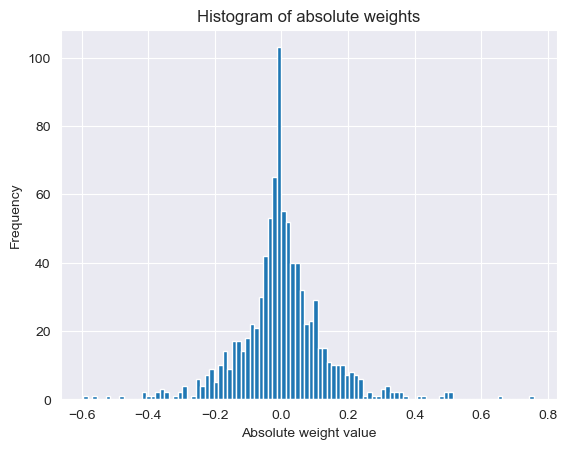

In [41]:
#weights before L1
plt.hist((modified_features_CV_logistic_regression.weights).flatten(), bins=100)
plt.xlabel("Absolute weight value")
plt.ylabel("Frequency")
plt.title("Histogram of absolute weights")
plt.show()

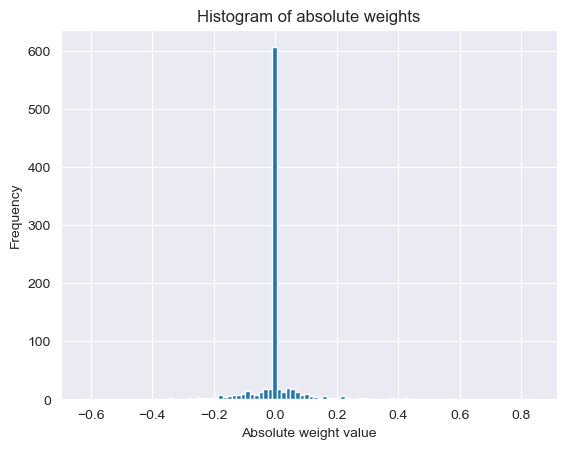

In [42]:
#weights after L1
plt.hist(logistic_regression_L1_reg.weights.flatten(), bins=100)
plt.xlabel("Absolute weight value")
plt.ylabel("Frequency")
plt.title("Histogram of absolute weights")
plt.show()


We can also see that mean accuracy before and after implemented L1 and L2 are very similar, thus can confirm that our model is not overfitted.

IV. Dataset balancing

Dataset balancing is crucial in model training because when we are training our data on some part of full dataset it can be possible that occurrence one class can be much bigger than others, so after training model on unbalanced dataset model can simply always guess this class which occurrence were the biggest in training set. It is oversampling, we have similar situation with undersampling when it's the other way around.

In [43]:
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
d_set = numerical_features_modified+categorical_features_modified

def sampling_method_pipeline(X_ttrain, y_ttrain, method):
    X_ttrain = X_ttrain.copy()
    y_ttrain = y_ttrain.copy()

    le = LabelEncoder()
    y_ttrain = le.fit_transform(y_ttrain.values.ravel() if isinstance(y_ttrain, pd.DataFrame) else y_ttrain)
    resampler = None
    # Resampling
    match method:
        case "SMOTE":
            resampler = SMOTENC(
            categorical_features=categorical_features_modified,
            random_state=42
            )
        case "RandomUnderSampler":
            resampler = RandomUnderSampler(random_state=42)
        case _:
            raise ValueError(f"Unknown method: {method}")

    X_resampled, y_resampled = resampler.fit_resample(X_ttrain, y_ttrain)

    return X_resampled, y_resampled

    ...

In [44]:
def make_cross_validation_predict_sampling(model, preproc, X_set, y_set, sampling_method=None, k=3):
    scores = []
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    y_encoded = LabelEncoder().fit_transform(y_set)

    for train_index, test_index in skf.split(X_set, y_encoded):
        X_train_raw = X_set.iloc[train_index]
        X_test_raw = X_set.iloc[test_index]

        y_train_raw = y_set.iloc[train_index]
        y_test_raw = y_set.iloc[test_index]

        if sampling_method is not None:
            X_train_resampled, y_train_resampled = sampling_method_pipeline(pd.DataFrame(X_train_raw), y_train_raw, sampling_method)
            X_train = X_train_resampled
            y_train = y_train_resampled
        else:
            X_train = X_train_raw
            y_train = y_train_raw.values.ravel()

        X_train = preproc.fit_transform(X_train)
        X_test = preproc.transform(X_test_raw)

        y_test_encoded = pd.get_dummies(y_test_raw).astype(int).to_numpy()
        y_train_encoded = pd.get_dummies(y_train).astype(int).to_numpy()

        model.fit(X_train, y_train_encoded)

        predicted = model.predict_class(X_test)
        score = model.score(predicted, y_test_encoded)
        scores.append(score)
        y_encoded_t =np.argmax(y_test_encoded,axis=1)
        print(classification_report(y_encoded_t, predicted, digits=4))

    return scores, np.mean(scores)



In [258]:
logistic_regression_L2 = BaseLogisticRegressionRegL2(n_iters=5000, lr=0.001, batch_size=64,l=0.001)
print(make_cross_validation_predict_sampling(logistic_regression_L2, modified_features_preprocessor, X_train, y_train,sampling_method="RandomUnderSampler"))

Iteration 0, Loss: 1.0566
Iteration 100, Loss: 0.7356
Iteration 200, Loss: 0.7009
Iteration 300, Loss: 0.6816
Iteration 400, Loss: 0.6679
Iteration 500, Loss: 0.6572
Iteration 600, Loss: 0.6483
Iteration 700, Loss: 0.6407
Iteration 800, Loss: 0.6342
Iteration 900, Loss: 0.6285
Iteration 1000, Loss: 0.6234
Iteration 1100, Loss: 0.6188
Iteration 1200, Loss: 0.6146
Iteration 1300, Loss: 0.6107
Iteration 1400, Loss: 0.6072
Iteration 1500, Loss: 0.6040
Iteration 1600, Loss: 0.6009
Iteration 1700, Loss: 0.5981
Iteration 1800, Loss: 0.5954
Iteration 1900, Loss: 0.5929
Iteration 2000, Loss: 0.5905
Iteration 2100, Loss: 0.5883
Iteration 2200, Loss: 0.5861
Iteration 2300, Loss: 0.5841
Iteration 2400, Loss: 0.5822
Iteration 2500, Loss: 0.5803
Iteration 2600, Loss: 0.5785
Iteration 2700, Loss: 0.5769
Iteration 2800, Loss: 0.5752
Iteration 2900, Loss: 0.5737
Iteration 3000, Loss: 0.5722
Iteration 3100, Loss: 0.5707
Iteration 3200, Loss: 0.5693
Iteration 3300, Loss: 0.5680
Iteration 3400, Loss: 0.56

In [46]:
from sklearn.metrics import classification_report

In [259]:
X_train_proc, X_test_proc, y_train_proc, y_test_proc = transform_in_pipeline(modified_features_preprocessor, X_train, X_test,y_train,y_test)
log_reg = BaseLogisticRegressionRegL2(n_iters=5000, lr=0.001, batch_size=64)
log_reg.fit(X_train_proc, y_train_proc)
predicted = log_reg.predict_class(X_test_proc)



Iteration 0, Loss: 0.9678
Iteration 100, Loss: 0.6002
Iteration 200, Loss: 0.5740
Iteration 300, Loss: 0.5601
Iteration 400, Loss: 0.5508
Iteration 500, Loss: 0.5439
Iteration 600, Loss: 0.5385
Iteration 700, Loss: 0.5341
Iteration 800, Loss: 0.5303
Iteration 900, Loss: 0.5271
Iteration 1000, Loss: 0.5243
Iteration 1100, Loss: 0.5217
Iteration 1200, Loss: 0.5195
Iteration 1300, Loss: 0.5174
Iteration 1400, Loss: 0.5156
Iteration 1500, Loss: 0.5139
Iteration 1600, Loss: 0.5123
Iteration 1700, Loss: 0.5108
Iteration 1800, Loss: 0.5095
Iteration 1900, Loss: 0.5082
Iteration 2000, Loss: 0.5071
Iteration 2100, Loss: 0.5060
Iteration 2200, Loss: 0.5049
Iteration 2300, Loss: 0.5040
Iteration 2400, Loss: 0.5030
Iteration 2500, Loss: 0.5022
Iteration 2600, Loss: 0.5013
Iteration 2700, Loss: 0.5006
Iteration 2800, Loss: 0.4998
Iteration 2900, Loss: 0.4991
Iteration 3000, Loss: 0.4984
Iteration 3100, Loss: 0.4978
Iteration 3200, Loss: 0.4972
Iteration 3300, Loss: 0.4966
Iteration 3400, Loss: 0.49

In [260]:
y_test_proc = np.argmax(y_test_proc,axis=1) if y_test_proc.ndim>1 else y_test_proc
print(classification_report(y_test_proc, predicted, digits=4))


              precision    recall  f1-score   support

           0     0.8113    0.7800    0.7954       441
           1     0.5500    0.3592    0.4346       245
           2     0.7917    0.9174    0.8499       642

    accuracy                         0.7688      1328
   macro avg     0.7177    0.6856    0.6933      1328
weighted avg     0.7536    0.7688    0.7552      1328



In [261]:
X_res_train,y_res_train = sampling_method_pipeline(X_train,y_train,method="SMOTE")
X_train_proc, X_test_proc, y_train_proc, y_test_proc = transform_in_pipeline(modified_features_preprocessor, X_res_train, X_test,y_res_train,y_test)
log_reg = BaseLogisticRegressionRegL2(n_iters=5000, lr=0.001, batch_size=64)
log_reg.fit(X_train_proc, y_train_proc)
predicted = log_reg.predict_class(X_test_proc)


Iteration 0, Loss: 0.9712
Iteration 100, Loss: 0.6439
Iteration 200, Loss: 0.6085
Iteration 300, Loss: 0.5897
Iteration 400, Loss: 0.5774
Iteration 500, Loss: 0.5686
Iteration 600, Loss: 0.5618
Iteration 700, Loss: 0.5563
Iteration 800, Loss: 0.5517
Iteration 900, Loss: 0.5479
Iteration 1000, Loss: 0.5445
Iteration 1100, Loss: 0.5416
Iteration 1200, Loss: 0.5390
Iteration 1300, Loss: 0.5368
Iteration 1400, Loss: 0.5347
Iteration 1500, Loss: 0.5328
Iteration 1600, Loss: 0.5312
Iteration 1700, Loss: 0.5296
Iteration 1800, Loss: 0.5282
Iteration 1900, Loss: 0.5269
Iteration 2000, Loss: 0.5257
Iteration 2100, Loss: 0.5246
Iteration 2200, Loss: 0.5235
Iteration 2300, Loss: 0.5226
Iteration 2400, Loss: 0.5217
Iteration 2500, Loss: 0.5208
Iteration 2600, Loss: 0.5200
Iteration 2700, Loss: 0.5193
Iteration 2800, Loss: 0.5186
Iteration 2900, Loss: 0.5179
Iteration 3000, Loss: 0.5173
Iteration 3100, Loss: 0.5167
Iteration 3200, Loss: 0.5161
Iteration 3300, Loss: 0.5156
Iteration 3400, Loss: 0.51

In [262]:
y_test_proc = np.argmax(y_test_proc,axis=1) if y_test_proc.ndim>1 else y_test_proc
print(classification_report(y_test_proc, predicted, digits=4))


              precision    recall  f1-score   support

           0     0.8406    0.7415    0.7880       441
           1     0.4533    0.5551    0.4991       245
           2     0.8372    0.8333    0.8353       642

    accuracy                         0.7515      1328
   macro avg     0.7104    0.7100    0.7074      1328
weighted avg     0.7675    0.7515    0.7575      1328



In [263]:
X_res_train,y_res_train = sampling_method_pipeline(X_train,y_train,method="RandomUnderSampler")

In [264]:
X_train_proc, X_test_proc, y_train_proc, y_test_proc = transform_in_pipeline(modified_features_preprocessor, X_res_train, X_test,y_res_train,y_test)
log_reg = BaseLogisticRegressionRegL2(n_iters=5000, lr=0.001, batch_size=64)
log_reg.fit(X_train_proc, y_train_proc)
predicted = log_reg.predict_class(X_test_proc)



Iteration 0, Loss: 1.0440
Iteration 100, Loss: 0.7177
Iteration 200, Loss: 0.6848
Iteration 300, Loss: 0.6662
Iteration 400, Loss: 0.6532
Iteration 500, Loss: 0.6433
Iteration 600, Loss: 0.6353
Iteration 700, Loss: 0.6288
Iteration 800, Loss: 0.6232
Iteration 900, Loss: 0.6184
Iteration 1000, Loss: 0.6141
Iteration 1100, Loss: 0.6103
Iteration 1200, Loss: 0.6069
Iteration 1300, Loss: 0.6038
Iteration 1400, Loss: 0.6009
Iteration 1500, Loss: 0.5983
Iteration 1600, Loss: 0.5958
Iteration 1700, Loss: 0.5936
Iteration 1800, Loss: 0.5915
Iteration 1900, Loss: 0.5895
Iteration 2000, Loss: 0.5876
Iteration 2100, Loss: 0.5858
Iteration 2200, Loss: 0.5842
Iteration 2300, Loss: 0.5826
Iteration 2400, Loss: 0.5811
Iteration 2500, Loss: 0.5797
Iteration 2600, Loss: 0.5784
Iteration 2700, Loss: 0.5771
Iteration 2800, Loss: 0.5758
Iteration 2900, Loss: 0.5747
Iteration 3000, Loss: 0.5735
Iteration 3100, Loss: 0.5724
Iteration 3200, Loss: 0.5714
Iteration 3300, Loss: 0.5704
Iteration 3400, Loss: 0.56

In [265]:
y_test_proc = np.argmax(y_test_proc,axis=1) if y_test_proc.ndim>1 else y_test_proc
print(classification_report(y_test_proc, predicted, digits=4))


              precision    recall  f1-score   support

           0     0.8464    0.7120    0.7734       441
           1     0.4448    0.6245    0.5195       245
           2     0.8450    0.8069    0.8255       642

    accuracy                         0.7417      1328
   macro avg     0.7121    0.7145    0.7061      1328
weighted avg     0.7716    0.7417    0.7517      1328



So here me made three runs of regression model to show differences between dataset without sampling and with sampling.
- I scores
We can see that this model ignores 1 class and favors 2 class, so we can assume that this is unbalanced dataset, because of better model correctness of dominated class, than minor class
- II scores (after balanced)
We can see that here was used some balanced techniques because of better balance between recall factor for all three classes
- III scores (after balanced)
This scores looks the best from this three because the recall value for all of them is high and similar to each other, so we don't have situation that model favours one of classes

V. Optimizing hiperparmeters

Out models have a variables that is constant during training our model so we have to be sure that our set values are good enough. To be sure we can optimizing it in `GridSearchCV`
We are working of logistic regression variances so we will optimize these parameters:
- `BaseLogisticRegresion` - `n_iter`  |  `lr`  |  `batch_size`
- `BaseLogisticRegressionRegCombined` - `n_iter`  |  `lr`  |  `batch_size` | `l` |`alpha`

In [48]:
from itertools import product
# BASE LOGISTIC REGRESSION
param_grid = {
    "n_iters":[3000,4000,5000,6000,7000,8000,9000,10000],
    "lr":[0.001,0.0001,0.00001],
    "batch_size":[32,64,128]
}
best = -1
best_params = None
keys = list(param_grid.keys())
combinations = list(product(*param_grid.values()))
for combo in combinations:
    params = dict(zip(keys,combo))
    model = BaseLogisticRegression(**params)
    mean = make_cross_validation_predict(model,
                                           modified_features_preprocessor,
                                           X_train, y_train,
                                           k=2)[1]
    if mean > best:
        best = mean
        best_params = params
print(best_params,best)

Iteration 0, Loss: 0.9720
Iteration 100, Loss: 0.6001
Iteration 200, Loss: 0.5682
Iteration 300, Loss: 0.5505
Iteration 400, Loss: 0.5387
Iteration 500, Loss: 0.5298
Iteration 600, Loss: 0.5228
Iteration 700, Loss: 0.5171
Iteration 800, Loss: 0.5121
Iteration 900, Loss: 0.5078
Iteration 1000, Loss: 0.5040
Iteration 1100, Loss: 0.5006
Iteration 1200, Loss: 0.4975
Iteration 1300, Loss: 0.4946
Iteration 1400, Loss: 0.4920
Iteration 1500, Loss: 0.4896
Iteration 1600, Loss: 0.4873
Iteration 1700, Loss: 0.4851
Iteration 1800, Loss: 0.4831
Iteration 1900, Loss: 0.4812
Iteration 2000, Loss: 0.4795
Iteration 2100, Loss: 0.4778
Iteration 2200, Loss: 0.4762
Iteration 2300, Loss: 0.4746
Iteration 2400, Loss: 0.4732
Iteration 2500, Loss: 0.4718
Iteration 2600, Loss: 0.4705
Iteration 2700, Loss: 0.4692
Iteration 2800, Loss: 0.4680
Iteration 2900, Loss: 0.4668
Iteration 0, Loss: 0.9634
Iteration 100, Loss: 0.5825
Iteration 200, Loss: 0.5542
Iteration 300, Loss: 0.5377
Iteration 400, Loss: 0.5260
Iter

In [54]:
from itertools import product
# BASE LOGISTIC REGRESSION WITH L1 L2
param_grid = {
    "n_iters":[4000,5000,6000],
    "lr":[0.001,0.0001,0.00001],
    "batch_size":[64,128],
    "l" :[0.001,0.0001,0.00001],
    "alpha" :[0.5,0.6,0.7,0.8,0.9]

}
best = -1
best_params = None
keys = list(param_grid.keys())
combinations = list(product(*param_grid.values()))
for i,combo in enumerate(combinations):
    print(i, len(combinations))
    params = dict(zip(keys,combo))
    model = BaseLogisticRegressionRegCombined(**params)
    mean = make_cross_validation_predict(model,
                                           modified_features_preprocessor,
                                           X_train, y_train,
                                           k=2)[1]
    if mean > best:
        best = mean
        best_params = params
print(best_params,best)

0 270
Iteration 0, Loss: 1.0218
Iteration 100, Loss: 0.6413
Iteration 200, Loss: 0.6107
Iteration 300, Loss: 0.5932
Iteration 400, Loss: 0.5812
Iteration 500, Loss: 0.5722
Iteration 600, Loss: 0.5651
Iteration 700, Loss: 0.5592
Iteration 800, Loss: 0.5543
Iteration 900, Loss: 0.5501
Iteration 1000, Loss: 0.5463
Iteration 1100, Loss: 0.5431
Iteration 1200, Loss: 0.5401
Iteration 1300, Loss: 0.5375
Iteration 1400, Loss: 0.5350
Iteration 1500, Loss: 0.5328
Iteration 1600, Loss: 0.5307
Iteration 1700, Loss: 0.5287
Iteration 1800, Loss: 0.5270
Iteration 1900, Loss: 0.5252
Iteration 2000, Loss: 0.5237
Iteration 2100, Loss: 0.5222
Iteration 2200, Loss: 0.5208
Iteration 2300, Loss: 0.5194
Iteration 2400, Loss: 0.5182
Iteration 2500, Loss: 0.5170
Iteration 2600, Loss: 0.5158
Iteration 2700, Loss: 0.5147
Iteration 2800, Loss: 0.5137
Iteration 2900, Loss: 0.5127
Iteration 3000, Loss: 0.5117
Iteration 3100, Loss: 0.5108
Iteration 3200, Loss: 0.5099
Iteration 3300, Loss: 0.5091
Iteration 3400, Loss

In [270]:
from itertools import product
# BASE LOGISTIC REGRESSION WITH L1 L2
param_grid = {
    "n_iters":[4000,5000,6000],
    "lr":[0.001,0.0001,0.00001],
    "batch_size":[64,128],
    "l" :[0.001,0.0001,0.00001],
}
best = -1
best_params = None
keys = list(param_grid.keys())
combinations = list(product(*param_grid.values()))
for i,combo in enumerate(combinations):
    print(i, len(combinations))
    params = dict(zip(keys,combo))
    model = BaseLogisticRegressionRegL2(**params)
    mean = make_cross_validation_predict(model,
                                           modified_features_preprocessor,
                                           X_train, y_train,
                                           k=2)[1]
    if mean > best:
        best = mean
        best_params = params
print(best_params,best)

0 36
Iteration 0, Loss: 1.0185
Iteration 100, Loss: 0.6062
Iteration 200, Loss: 0.5740
Iteration 300, Loss: 0.5562
Iteration 400, Loss: 0.5443
Iteration 500, Loss: 0.5355
Iteration 600, Loss: 0.5286
Iteration 700, Loss: 0.5229
Iteration 800, Loss: 0.5182
Iteration 900, Loss: 0.5141
Iteration 1000, Loss: 0.5105
Iteration 1100, Loss: 0.5073
Iteration 1200, Loss: 0.5045
Iteration 1300, Loss: 0.5019
Iteration 1400, Loss: 0.4995
Iteration 1500, Loss: 0.4973
Iteration 1600, Loss: 0.4953
Iteration 1700, Loss: 0.4934
Iteration 1800, Loss: 0.4916
Iteration 1900, Loss: 0.4899
Iteration 2000, Loss: 0.4884
Iteration 2100, Loss: 0.4869
Iteration 2200, Loss: 0.4855
Iteration 2300, Loss: 0.4842
Iteration 2400, Loss: 0.4830
Iteration 2500, Loss: 0.4818
Iteration 2600, Loss: 0.4806
Iteration 2700, Loss: 0.4796
Iteration 2800, Loss: 0.4785
Iteration 2900, Loss: 0.4775
Iteration 3000, Loss: 0.4766
Iteration 3100, Loss: 0.4757
Iteration 3200, Loss: 0.4748
Iteration 3300, Loss: 0.4739
Iteration 3400, Loss:

WVI. Ensemble methods

In [66]:
# Defining correlation matrix
print(X_train.columns)

Index(['Application order', 'Age at enrollment',
       'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (without evaluations)',
       'Curricular units 2nd sem (grade)', 'Marital status',
       'Application mode', 'Course', 'Daytime/evening attendance',
       'Previous qualification', 'Mother's qualification',
       'Father's qualification', 'Mother's occupation', 'Father's occupation',
       'Displaced', 'Educational special needs', 'Debtor',
       'Tuition fees up to date', 'Gender', 'Scholarship holder'],
      dtype='object')


Iteration 0, Loss: 0.9677
Iteration 100, Loss: 0.5998
Iteration 200, Loss: 0.5735
Iteration 300, Loss: 0.5593
Iteration 400, Loss: 0.5498
Iteration 500, Loss: 0.5428
Iteration 600, Loss: 0.5372
Iteration 700, Loss: 0.5326
Iteration 800, Loss: 0.5287
Iteration 900, Loss: 0.5253
Iteration 1000, Loss: 0.5223
Iteration 1100, Loss: 0.5196
Iteration 1200, Loss: 0.5172
Iteration 1300, Loss: 0.5150
Iteration 1400, Loss: 0.5130
Iteration 1500, Loss: 0.5111
Iteration 1600, Loss: 0.5094
Iteration 1700, Loss: 0.5078
Iteration 1800, Loss: 0.5063
Iteration 1900, Loss: 0.5048
Iteration 2000, Loss: 0.5035
Iteration 2100, Loss: 0.5023
Iteration 2200, Loss: 0.5011
Iteration 2300, Loss: 0.5000
Iteration 2400, Loss: 0.4989
Iteration 2500, Loss: 0.4979
Iteration 2600, Loss: 0.4969
Iteration 2700, Loss: 0.4960
Iteration 2800, Loss: 0.4951
Iteration 2900, Loss: 0.4943
Iteration 3000, Loss: 0.4935
Iteration 3100, Loss: 0.4927
Iteration 3200, Loss: 0.4920
Iteration 3300, Loss: 0.4912
Iteration 3400, Loss: 0.49

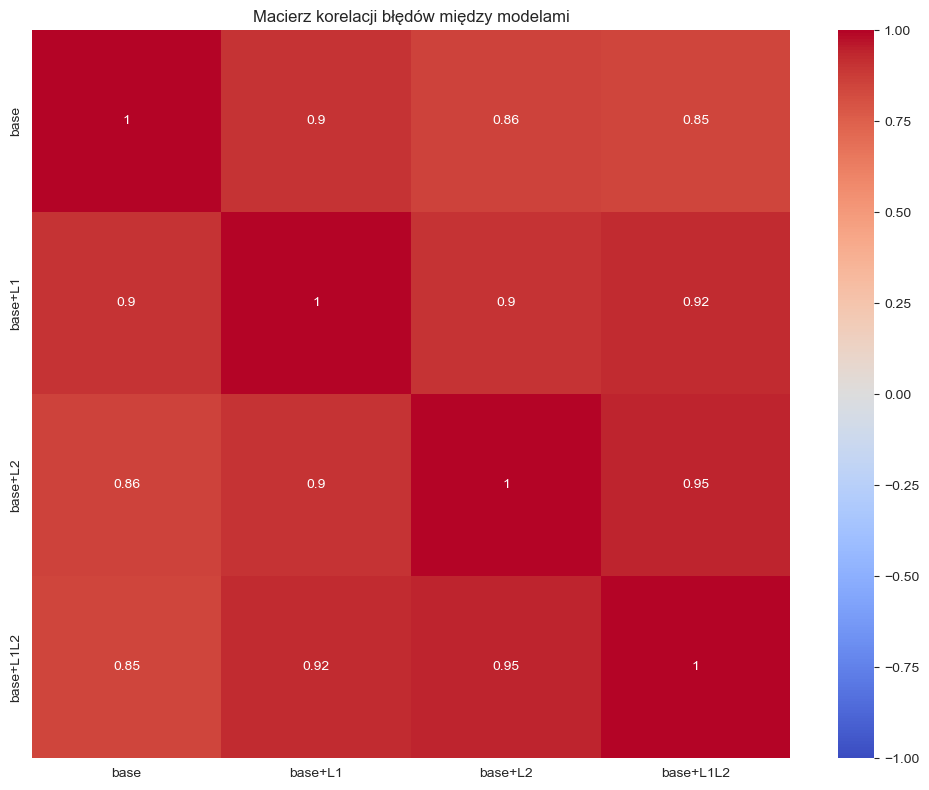

In [313]:
import seaborn as sns
X_train_proc1, X_test_proc1, y_train_proc1, y_test_proc1 = transform_in_pipeline(
    modified_features_preprocessor, X_train, X_test, y_train, y_test)

X_train_proc2, X_test_proc2, y_train_proc2, y_test_proc2 = transform_in_pipeline(
    preprocessor_full_set, X_train, X_test, y_train, y_test)
base = BaseLogisticRegression(n_iters=5000, lr=0.001, batch_size=64)
base_L1 = BaseLogisticRegressionRegL1(n_iters=5000, lr=0.001, batch_size=64, l=0.001)
base_L2 =BaseLogisticRegressionRegL2(n_iters=5000, lr=0.001, batch_size=64, l=0.001)
base_L1L2 = BaseLogisticRegressionRegCombined(n_iters=5000, lr=0.001, batch_size=64, l=0.00101, alpha=0.70)
models_list = [
    (base, "base",1),
    (base_L1, "base+L1",1),
    (base_L2, "base+L2",2),
    (base_L1L2, "base+L1L2",2)
]

trained_models = []
for model, name,num in models_list:
    if num==1:
        model.fit(X_train_proc1,y_train_proc1)
    if num==2:
        model.fit(X_train_proc2,y_train_proc2)
    trained_models.append((model, name,num))

predictions = {}
errors = {}

for model, name,num in trained_models:
    if num==1:
        y_pred = model.predict_class(X_test_proc1)
        predictions[name] = y_pred
        y_true = np.argmax(y_test_proc1, axis=1) if y_test_proc1.ndim > 1 else y_test_proc1
        errors[name] = (y_pred.flatten() != y_true).astype(int)
    if num==2:
        y_pred = model.predict_class(X_test_proc2)
        predictions[name] = y_pred
        y_true = np.argmax(y_test_proc2, axis=1) if y_test_proc2.ndim > 1 else y_test_proc2
        errors[name] = (y_pred.flatten() != y_true).astype(int)



errors_df = pd.DataFrame(errors)

error_correlation = errors_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(error_correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Macierz korelacji błędów między modelami')
plt.tight_layout()
plt.show()

We can see on this matrix that base model and base_L1L2 model has the lowest correlation score so they are better in different records (but still this is high correlation score)

Ensemble methods:
- HardVotingClassifier
Here we have n classifiers and every of that returning their prediction for every record, HardVotingClassifier choose the most frequent label  and this is final prediction

- StackingClassifier

In [280]:
models = [
    BaseLogisticRegression(n_iters=7000, lr=0.001, batch_size=64),
    BaseLogisticRegressionRegCombined(n_iters=4000, lr=0.001, batch_size=128, l=0.0010, alpha=0.50)
    ]
def HardVotingClassifier(models,X_train,y_train,X_test,y_test):
    models[0].fit(X_train,y_train)
    models[1].fit(X_train,y_train)
    y_pred_1 = models[0].predict_class(X_test)
    y_pred_2 = models[1].predict_class(X_test)
    pred = []
    for row1,row2 in zip(y_pred_1,y_pred_2):
        d ={0:0,1:0,2:0}
        for elem in row1:
            d[elem]+=1
        for elem in row2:
            d[elem]+=1
        pred.append(max(d, key=d.get))

    return pred

In [281]:
pred = HardVotingClassifier(models,X_train_proc1,y_train_proc1,X_test_proc1,y_test_proc1)
p = np.array(pred)
def score(predicted, y):
    y_true = np.argmax(y, axis=1)
    correct = (predicted.flatten() == y_true)
    accuracy = np.mean(correct)
    return accuracy
score(p,y_test_proc1)

Iteration 0, Loss: 0.9673
Iteration 100, Loss: 0.5999
Iteration 200, Loss: 0.5736
Iteration 300, Loss: 0.5594
Iteration 400, Loss: 0.5499
Iteration 500, Loss: 0.5428
Iteration 600, Loss: 0.5372
Iteration 700, Loss: 0.5326
Iteration 800, Loss: 0.5287
Iteration 900, Loss: 0.5253
Iteration 1000, Loss: 0.5223
Iteration 1100, Loss: 0.5196
Iteration 1200, Loss: 0.5172
Iteration 1300, Loss: 0.5150
Iteration 1400, Loss: 0.5130
Iteration 1500, Loss: 0.5111
Iteration 1600, Loss: 0.5094
Iteration 1700, Loss: 0.5078
Iteration 1800, Loss: 0.5063
Iteration 1900, Loss: 0.5049
Iteration 2000, Loss: 0.5035
Iteration 2100, Loss: 0.5023
Iteration 2200, Loss: 0.5011
Iteration 2300, Loss: 0.5000
Iteration 2400, Loss: 0.4989
Iteration 2500, Loss: 0.4979
Iteration 2600, Loss: 0.4969
Iteration 2700, Loss: 0.4960
Iteration 2800, Loss: 0.4951
Iteration 2900, Loss: 0.4943
Iteration 3000, Loss: 0.4935
Iteration 3100, Loss: 0.4927
Iteration 3200, Loss: 0.4920
Iteration 3300, Loss: 0.4912
Iteration 3400, Loss: 0.49

np.float64(0.7688253012048193)

In [322]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

def make_cross_validation_predict_voting(models, preproc, X_set, y_set, k=3):
    scores = []
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    y_encoded = LabelEncoder().fit_transform(y_set)

    for train_index, test_index in skf.split(X_set, y_encoded):
        X_train_raw = X_set.iloc[train_index]
        X_test_raw = X_set.iloc[test_index]

        y_train_raw = y_set.iloc[train_index]
        y_test_raw = y_set.iloc[test_index]

        # Preprocessing
        X_train = preproc.fit_transform(X_train_raw)
        X_test = preproc.transform(X_test_raw)

        # One-hot encode targets for training
        y_train = pd.get_dummies(y_train_raw).astype(int).to_numpy()
        y_test = pd.get_dummies(y_test_raw).astype(int).to_numpy()

        # Fit both models
        models[0].fit(X_train, y_train)
        models[1].fit(X_train, y_train)

        # Predict
        y_pred_1 = models[0].predict_class(X_test)
        y_pred_2 = models[1].predict_class(X_test)

        # Hard voting
        pred = []
        for row1, row2 in zip(y_pred_1, y_pred_2):
            d = {0: 0, 1: 0, 2: 0}
            for elem in row1:
                d[elem] += 1
            for elem in row2:
                d[elem] += 1
            pred.append(max(d, key=d.get))

        pred = np.array(pred)

        # Use your custom scoring
        fold_score = score(pred, y_test)
        scores.append(fold_score)

    return scores, np.mean(scores)

def score(predicted, y):
    y_true = np.argmax(y, axis=1)
    correct = (predicted.flatten() == y_true)
    return np.mean(correct)
print(make_cross_validation_predict_voting(models, modified_features_preprocessor, X_train, y_train))

Iteration 0, Loss: 1.0024
Iteration 100, Loss: 0.6156
Iteration 200, Loss: 0.5868
Iteration 300, Loss: 0.5709
Iteration 400, Loss: 0.5599
Iteration 500, Loss: 0.5516
Iteration 600, Loss: 0.5451
Iteration 700, Loss: 0.5396
Iteration 800, Loss: 0.5349
Iteration 900, Loss: 0.5309
Iteration 1000, Loss: 0.5273
Iteration 1100, Loss: 0.5241
Iteration 1200, Loss: 0.5212
Iteration 1300, Loss: 0.5185
Iteration 1400, Loss: 0.5161
Iteration 1500, Loss: 0.5138
Iteration 1600, Loss: 0.5117
Iteration 1700, Loss: 0.5098
Iteration 1800, Loss: 0.5079
Iteration 1900, Loss: 0.5062
Iteration 2000, Loss: 0.5045
Iteration 2100, Loss: 0.5029
Iteration 2200, Loss: 0.5015
Iteration 2300, Loss: 0.5000
Iteration 2400, Loss: 0.4987
Iteration 2500, Loss: 0.4974
Iteration 2600, Loss: 0.4962
Iteration 2700, Loss: 0.4950
Iteration 2800, Loss: 0.4938
Iteration 2900, Loss: 0.4927
Iteration 3000, Loss: 0.4917
Iteration 3100, Loss: 0.4907
Iteration 3200, Loss: 0.4897
Iteration 3300, Loss: 0.4887
Iteration 3400, Loss: 0.48

In [282]:
models = [
    BaseLogisticRegression(n_iters=7000, lr=0.001, batch_size=64),
    BaseLogisticRegressionRegCombined(n_iters=4000, lr=0.001, batch_size=128, l=0.0010, alpha=0.50)
    ]
def StackingClassifier(models,X_train,y_train,X_test,y_test):
    models[0].fit(X_train,y_train)
    models[1].fit(X_train,y_train)
    models[0].predict_class(X_test)
    models[1].predict_class(X_test)
    prob1 = models[0].probabilities
    prob2 = models[1].probabilities
    results = []
    for row1,row2 in zip(prob1,prob2):
        c = np.hstack((row1,row2))
        results.append(c)
    return np.array(results)

In [283]:
pred = StackingClassifier(models,X_train_proc1,y_train_proc1,X_test_proc1,y_test_proc1)
pred

Iteration 0, Loss: 0.9686
Iteration 100, Loss: 0.5999
Iteration 200, Loss: 0.5735
Iteration 300, Loss: 0.5593
Iteration 400, Loss: 0.5498
Iteration 500, Loss: 0.5428
Iteration 600, Loss: 0.5372
Iteration 700, Loss: 0.5326
Iteration 800, Loss: 0.5287
Iteration 900, Loss: 0.5253
Iteration 1000, Loss: 0.5223
Iteration 1100, Loss: 0.5196
Iteration 1200, Loss: 0.5172
Iteration 1300, Loss: 0.5150
Iteration 1400, Loss: 0.5130
Iteration 1500, Loss: 0.5111
Iteration 1600, Loss: 0.5094
Iteration 1700, Loss: 0.5078
Iteration 1800, Loss: 0.5063
Iteration 1900, Loss: 0.5049
Iteration 2000, Loss: 0.5035
Iteration 2100, Loss: 0.5023
Iteration 2200, Loss: 0.5011
Iteration 2300, Loss: 0.5000
Iteration 2400, Loss: 0.4989
Iteration 2500, Loss: 0.4979
Iteration 2600, Loss: 0.4969
Iteration 2700, Loss: 0.4960
Iteration 2800, Loss: 0.4951
Iteration 2900, Loss: 0.4943
Iteration 3000, Loss: 0.4935
Iteration 3100, Loss: 0.4927
Iteration 3200, Loss: 0.4920
Iteration 3300, Loss: 0.4913
Iteration 3400, Loss: 0.49

array([[0.91125599, 0.08585787, 0.00288615, 0.78213382, 0.21313988,
        0.0047263 ],
       [0.01309751, 0.05657464, 0.93032785, 0.0361788 , 0.11411735,
        0.84970385],
       [0.09053526, 0.08566188, 0.82380286, 0.04992944, 0.0796161 ,
        0.87045446],
       ...,
       [0.1270732 , 0.25415816, 0.61876864, 0.10354732, 0.22965815,
        0.66679452],
       [0.0812477 , 0.38812411, 0.53062819, 0.12478515, 0.37268835,
        0.50252649],
       [0.3543586 , 0.14787654, 0.49776485, 0.3530222 , 0.17206944,
        0.47490837]], shape=(1328, 6))

In [284]:
y =y_test_proc1.copy()
model = BaseLogisticRegressionRegCombined(n_iters=4000, lr=0.001,batch_size=128,l=0.001, alpha=0.5)
model.fit(pred, y)
predicted = model.predict_class(pred)
model.score(predicted, y_test_proc1)


Iteration 0, Loss: 1.0960
Iteration 100, Loss: 0.9140
Iteration 200, Loss: 0.8216
Iteration 300, Loss: 0.7666
Iteration 400, Loss: 0.7302
Iteration 500, Loss: 0.7044
Iteration 600, Loss: 0.6852
Iteration 700, Loss: 0.6704
Iteration 800, Loss: 0.6585
Iteration 900, Loss: 0.6489
Iteration 1000, Loss: 0.6409
Iteration 1100, Loss: 0.6342
Iteration 1200, Loss: 0.6285
Iteration 1300, Loss: 0.6236
Iteration 1400, Loss: 0.6194
Iteration 1500, Loss: 0.6157
Iteration 1600, Loss: 0.6125
Iteration 1700, Loss: 0.6096
Iteration 1800, Loss: 0.6071
Iteration 1900, Loss: 0.6049
Iteration 2000, Loss: 0.6029
Iteration 2100, Loss: 0.6011
Iteration 2200, Loss: 0.5995
Iteration 2300, Loss: 0.5981
Iteration 2400, Loss: 0.5968
Iteration 2500, Loss: 0.5956
Iteration 2600, Loss: 0.5945
Iteration 2700, Loss: 0.5935
Iteration 2800, Loss: 0.5926
Iteration 2900, Loss: 0.5918
Iteration 3000, Loss: 0.5911
Iteration 3100, Loss: 0.5904
Iteration 3200, Loss: 0.5897
Iteration 3300, Loss: 0.5891
Iteration 3400, Loss: 0.58

np.float64(0.7643072289156626)

In [328]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import pandas as pd

def score(predicted, y):
    y_true = np.argmax(y, axis=1)
    correct = (predicted.flatten() == y_true)
    return np.mean(correct)

def make_cross_validation_predict_stacking(model_factories, meta_model_factory, preproc, X_set, y_set, k=5):
    scores = []
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    y_encoded = LabelEncoder().fit_transform(y_set)

    for train_index, test_index in skf.split(X_set, y_encoded):
        X_train_raw = X_set.iloc[train_index]
        X_test_raw = X_set.iloc[test_index]
        y_train_raw = y_set.iloc[train_index]
        y_test_raw = y_set.iloc[test_index]

        # preprocess
        X_train = preproc.fit_transform(X_train_raw)
        X_test = preproc.transform(X_test_raw)

        y_train = pd.get_dummies(y_train_raw).astype(int).to_numpy()
        y_test = pd.get_dummies(y_test_raw).astype(int).to_numpy()

        base_preds_train = []
        base_preds_test = []

        for factory in model_factories:
            model = factory()
            model.fit(X_train, y_train)

            pred_train = model.predict_class(X_train)
            pred_test = model.predict_class(X_test)

            # flatten one-hot or probability to class
            pred_train = np.array([np.bincount(row).argmax() for row in pred_train])
            pred_test = np.array([np.bincount(row).argmax() for row in pred_test])

            base_preds_train.append(pred_train.reshape(-1, 1))
            base_preds_test.append(pred_test.reshape(-1, 1))

        stacked_train = np.hstack(base_preds_train)
        stacked_test = np.hstack(base_preds_test)


        meta_model = meta_model_factory()
        meta_model.fit(stacked_train, y_train)

        final_pred = meta_model.predict_class(stacked_test)
        final_pred = np.array([np.bincount(row).argmax() for row in final_pred])

        fold_score = score(final_pred, y_test)
        scores.append(fold_score)

    return scores, np.mean(scores)
model_factories = [
    lambda: BaseLogisticRegression(n_iters=5000, lr=0.001),
    lambda: BaseLogisticRegressionRegCombined(n_iters=4000, lr=0.001, batch_size=128, l=0.0010, alpha=0.50)
]

meta_model_factory = lambda: BaseLogisticRegression(n_iters=3000, lr=0.001)

scores, mean_score = make_cross_validation_predict_stacking(
    model_factories,
    meta_model_factory,
    modified_features_preprocessor,
    X_train,
    y_train,
    k=3
)

print("Fold scores:", scores)
print("Mean score:", mean_score)


Iteration 0, Loss: 1.0020
Iteration 100, Loss: 0.6156
Iteration 200, Loss: 0.5868
Iteration 300, Loss: 0.5708
Iteration 400, Loss: 0.5599
Iteration 500, Loss: 0.5516
Iteration 600, Loss: 0.5451
Iteration 700, Loss: 0.5396
Iteration 800, Loss: 0.5350
Iteration 900, Loss: 0.5309
Iteration 1000, Loss: 0.5273
Iteration 1100, Loss: 0.5241
Iteration 1200, Loss: 0.5212
Iteration 1300, Loss: 0.5186
Iteration 1400, Loss: 0.5161
Iteration 1500, Loss: 0.5139
Iteration 1600, Loss: 0.5117
Iteration 1700, Loss: 0.5098
Iteration 1800, Loss: 0.5079
Iteration 1900, Loss: 0.5062
Iteration 2000, Loss: 0.5045
Iteration 2100, Loss: 0.5030
Iteration 2200, Loss: 0.5015
Iteration 2300, Loss: 0.5000
Iteration 2400, Loss: 0.4987
Iteration 2500, Loss: 0.4974
Iteration 2600, Loss: 0.4962
Iteration 2700, Loss: 0.4950
Iteration 2800, Loss: 0.4938
Iteration 2900, Loss: 0.4927
Iteration 3000, Loss: 0.4917
Iteration 3100, Loss: 0.4907
Iteration 3200, Loss: 0.4897
Iteration 3300, Loss: 0.4887
Iteration 3400, Loss: 0.48



VII. Mixture of Experts
Mixture of experts is a method where "supervisor" assigns weight (in meaning of importance of particular model from experts models embedded in this method). This "supervisor" here is called Gating Network - this is way to assign a value of trust to each model


In [207]:
X_train_proc1, X_test_proc1, y_train_proc1, y_test_proc1 = transform_in_pipeline(
    modified_features_preprocessor, X_train, X_test, y_train, y_test)

In [228]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np

class MixtureOfExperts:
    def __init__(self, model1, model2, num_classes):
        self.model1 = model1
        self.model2 = model2
        self.gating_model = RandomForestClassifier()
        self.num_classes = num_classes

    def fit(self, X_train, y_train):
        self.model1.fit(X_train, y_train)
        self.model2.fit(X_train, y_train)

        self.model1.predict_class(X_train)
        proba1 = self.model1.probabilities
        self.model2.predict_class(X_train)
        proba2 = self.model1.probabilities

        if len(y_train.shape) > 1:
            y_true = np.argmax(y_train, axis=1)
        else:
            y_true = y_train

        X_gating_train = []
        gating_labels = []

        for i in range(len(X_train)):
            pred1 = np.argmax(proba1[i])
            pred2 = np.argmax(proba2[i])

            acc1 = int(pred1 == y_true[i])
            acc2 = int(pred2 == y_true[i])

            if acc1 > acc2:
                label = 0
            elif acc2 > acc1:
                label = 1
            else:
                label = i % 2  #random

            features = np.concatenate([
                X_train[i].flatten(),
                proba1[i],
                proba2[i],
                np.abs(proba1[i] - proba2[i])
            ])
            X_gating_train.append(features)
            gating_labels.append(label)

        X_gating_train = np.array(X_gating_train)
        gating_labels = np.array(gating_labels)

        if len(gating_labels) == 0:
            raise ValueError("Brak danych do treningu gating modelu.")

        self.gating_model.fit(X_gating_train, gating_labels)

    def predict(self, X_test):
        self.model1.predict_class(X_test)
        proba1 = self.model1.probabilities
        self.model2.predict_class(X_test)
        proba2 = self.model1.probabilities

        X_gating_test = []
        for i in range(len(X_test)):
            features = np.concatenate([
                X_test[i].flatten(),
                proba1[i],
                proba2[i],
                np.abs(proba1[i] - proba2[i])
            ])
            X_gating_test.append(features)
        X_gating_test = np.array(X_gating_test)

        gating_probs = self.gating_model.predict_proba(X_gating_test)

        final_preds = []
        for i in range(len(X_test)):
            weighted_vote = gating_probs[i][0] * proba1[i] + gating_probs[i][1] * proba2[i]
            final_preds.append(np.argmax(weighted_vote))
        return np.array(final_preds)

    def score(self, X_test, y_test):
        preds = self.predict(X_test)
        if len(y_test.shape) > 1:
            y_true = np.argmax(y_test, axis=1)
        else:
            y_true = y_test
        return np.mean(preds == y_true)


First, we train our expert models independently. Then, for each record in the training data, we determine which expert made the correct prediction. Based on this, we build a gating matrix, which learns to identify which expert is more likely to be correct given a specific input sample X

During prediction, for each test record, we retrieve the class probability distributions from both experts. We then weight these probabilities using the gating model's output (i.e., its trust in each expert). Finally, we combine the weighted predictions and select the class with the highest final score as the predicted class.

In [229]:
m1 = BaseLogisticRegression(n_iters=7000, lr=0.001, batch_size=64)
m2 = BaseLogisticRegressionRegCombined(n_iters=4000, lr=0.001, batch_size=128, l=0.00101, alpha=0.70)
moe = MixtureOfExperts(m1, m2,3)
moe.fit(X_train_proc1, y_train_proc1)
acc = moe.score(X_test_proc1, y_test_proc1)
print(f"Mixture of Experts accuracy: {acc:.4f}")


Mixture of Experts accuracy: 0.7673


In [330]:
from sklearn.model_selection import GridSearchCV, train_test_split
df = pd.read_csv("dataset.csv")
X = df.drop(["Target"],axis=1)
df["Target"] = LabelEncoder().fit_transform(df["Target"])
y = df["Target"]

In [336]:
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features_modified),
    ('cat', categorical_pipeline, categorical_features_modified)
])


random_forest_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier())
])

# Siatka hiperparametrów
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Grid Search
grid_search = GridSearchCV(random_forest_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Wyniki
print( grid_search.best_params_)
print(grid_search.best_score_)

{'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}
0.7742310550667658


np.float64(0.774513940498166)